In [1]:
import pickle
import itertools
import open3d as o3d
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from scipy import interpolate
from scipy import ndimage

In [3]:
import sklearn
from sklearn.decomposition import PCA
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import pathlib

In [4]:
def clustering(cfs_part):
    flatten_curve_frag = np.array(list(itertools.chain.from_iterable(cfs_part)))
    pcd.points = o3d.utility.Vector3dVector(flatten_curve_frag)
    labels = np.array(pcd.cluster_dbscan(eps=0.005, min_points=10))
    unique, freq = np.unique(labels, return_counts=True)
    mode = unique[np.argmax(freq)]
    flatten_curve_frag = flatten_curve_frag[labels==mode]
    return flatten_curve_frag
    
def same_checker(ls):
    for i, num1 in enumerate(ls):
        for j, num2 in enumerate(ls):
            if i == j:
                continue
            if np.abs(num1 - num2) <0.0005:
                return num1

def sort_cluster(cluster):
    pca = PCA()
    pca.fit(cluster)
    feature = pca.transform(cluster)

    r = (feature[:, 0]**2 + feature[:, 1]**2)**(1/2)
    cos = feature[:, 0]/r
    sin = feature[:, 1]/r

    arccos = np.arccos(cos)
    arcsin = np.arcsin(sin)
    arccos_m = -arccos
    arcsin_m = -np.pi -arcsin
    arcsin_p = np.pi - arcsin
    
    feature_theta = []
    for temp_list in zip(arccos, arcsin, arccos_m, arcsin_m, arcsin_p):
        theta = same_checker(temp_list)
        feature_theta.append(theta)
    feature_theta = np.array(feature_theta)
    
    cluster_ex_nan = cluster[np.where(feature_theta != None)]
    feature_theta_ex_nan = feature_theta[np.where(feature_theta != None)]
    sorted_theta = np.sort(feature_theta_ex_nan)
    sorted_idx = np.argsort(feature_theta_ex_nan)
    sorted_cluster = cluster_ex_nan[sorted_idx]
    return sorted_cluster, sorted_theta

def outlier_removal(sorted_cluster, theta):
    x = sorted_cluster[:,0]
    y = sorted_cluster[:,2]
    z = sorted_cluster[:,1]
    data = [x,y,z]

    #jump = np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2) 
    #smooth_jump = ndimage.gaussian_filter1d(jump, 5, mode='wrap')  # window of size 5 is arbitrary
    #limit = 2*np.median(smooth_jump)    # factor 2 is arbitrary
    #xn, yn, zn = x[:-1], y[:-1], z[:-1]
    #theta = theta[:-1]
    #xn = xn[(jump > 0) & (smooth_jump < limit)]
    #yn = yn[(jump > 0) & (smooth_jump < limit)]
    #zn = zn[(jump > 0) & (smooth_jump < limit)]
    #theta = theta[(jump > 0) & (smooth_jump < limit)]
    #data = [xn,yn,zn]
    return data, theta

def organize_data(flatten_curve_frag):
    sorted_cluster, theta = sort_cluster(flatten_curve_frag)
    data, theta = outlier_removal(sorted_cluster, theta)
    
    return data, theta

In [5]:
def polar_transformation(points, order=(0,2,1)):
    ordered_points = points[:, order]
    r = np.sqrt(np.sum(np.square(ordered_points), axis=1))
    theta = np.arccos(ordered_points[:,2]/r)
    phi = np.sign(ordered_points[:,1]) * np.arccos(ordered_points[:,0]/np.sqrt(np.sum(np.square(ordered_points[:,0:2]), axis=1)))
    return [r, theta, phi]

def inverse_polar_transformation(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return [x, y, z]

def same_phi_delete(phi, x, y, z):
    xyz = np.array([[np.average(x[phi == uni]), np.average(y[phi == uni]), np.average(z[phi == uni])] for uni in np.unique(phi)])
    return np.unique(phi), xyz

def data_processing(r, theta, phi):
    sorted_idx = np.argsort(phi)
    r, theta, phi = r[sorted_idx], theta[sorted_idx], phi[sorted_idx]
    x, y, z = inverse_polar_transformation(r, theta, phi)
    phi, xyz = same_phi_delete(phi, x, y, z)
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    x, y, z= np.concatenate([x, [x[0]]]), np.concatenate([y, [y[0]]]), np.concatenate([z, [z[0]]])
    phi = np.concatenate([phi, [2*np.pi]])
    ys = np.array([x, y])
    return phi, x, y, z

def bspline(phi, ys):
    xx = np.linspace(-np.pi, np.pi, 1000)
    k=5
    t = [-1, 0, 1]
    t = np.r_[(phi[0],)*(k+1), t, (phi[-1],)*(k+1)]
    bspl = interpolate.make_interp_spline(phi, ys, k=k, axis=1)
    return bspl(xx)

def cfs_processing(cfs):
    data_list = []
    for i in range(len(cfs)):
        flatten_curve_frag = np.array(list(itertools.chain.from_iterable(cfs[i])))
        points = flatten_curve_frag
        r, theta, phi = polar_transformation(points)
        phi, x, y, z = data_processing(r, theta, phi)
        data, theta = organize_data(np.array([x, y, z]).T)
        data = np.array(data)[(0,2,1),:]
        data_list.append(data)
    return data_list

def bspline_all_leaf(data_list):
    s_curve_list = []
    for i in range(len(data_list)):
        point_num = np.array(data_list[i]).shape[-1]
        skip = int(point_num/100)
        prossed_data = np.array(data_list[i])[:,::skip]
        w=np.ones(len(prossed_data[0]))

        w[::100] = 100
        tck, u = interpolate.splprep(prossed_data, w=w, per=1, s=0.001, k=3)
        new = interpolate.splev(u, tck, der=0)

        prossed_data = np.array(new)

        smooth_curve = np.stack([prossed_data[0],prossed_data[1],prossed_data[2]],axis=1)
        s_curve_list.append(smooth_curve)
    return s_curve_list

In [6]:
def edges_to_lineset(mesh, edges, color):
    ls = o3d.geometry.LineSet()
    ls.points = mesh.vertices
    ls.lines = edges
    colors = np.empty((np.asarray(edges).shape[0], 3))
    colors[:] = color
    ls.colors = o3d.utility.Vector3dVector(colors)
    return ls

def rotation_mat(angle):
    Rx = np.array([[1,0,0],
                 [0, np.cos(angle[0]), -np.sin(angle[0])],
                 [0, np.sin(angle[0]), np.cos(angle[0])]])

    Ry = np.array([[np.cos(angle[1]), 0, np.sin(angle[1])],
                 [0,1,0],
                 [-np.sin(angle[1]), 0, np.cos(angle[1])]])

    Rz = np.array([[np.cos(angle[2]), -np.sin(angle[2]), 0],
                 [np.sin(angle[2]), np.cos(angle[2]), 0],
                 [0,0,1]])
    return Rz@Rx@Ry

angle = [np.pi, np.pi, 0] # pcd.rotate()
#angle = [-np.pi/2, np.pi/2, np.pi/2]
R = rotation_mat(angle)
R_mirror = np.array([[-1,0,0],
                    [0,1,0],
                    [0,0,1]])

In [7]:
def get_pts(mesh, edges, max_point_num=10000):
    vertices = np.asarray(mesh.vertices)
    edges = np.asarray(edges)
    dist = 0
    for i in range(len(vertices[edges])):
        start = vertices[edges][i][0]
        end = vertices[edges][i][1]
        dist_part = np.sqrt(np.sum(np.square(start - end)))
        dist += dist_part
    unit_dist = dist/max_point_num
    next_start_length = 0
    next_start_partation = 0
    pts_list = []
    for i in range(len(vertices[edges])):
        start = vertices[edges][i][0]
        end = vertices[edges][i][1]
        next_st_pt = start + (end - start)*next_start_partation
        dist_part = np.sqrt(np.sum(np.square(start - end)))
        dist_nx = np.sqrt(np.sum(np.square(next_st_pt - end)))
        pts_num = int(dist_nx/unit_dist)+1
        pts = next_st_pt + np.repeat(np.arange(pts_num),3).reshape((pts_num,3)) * (end - next_st_pt)/(pts_num-1)
        end_pts = pts[-1]
        next_start_length = pts_num*unit_dist - dist_part + next_start_length
        next_start_partation = next_start_length/dist_part
        pts_list.append(pts)

    pts_array = np.concatenate(pts_list)

    return pts_array

def cal_emd(ind, s_curve_list):
    rng = np.random.default_rng(123)
    mesh = o3d.io.read_triangle_mesh("polygon/quan_e_a/{}.ply".format(ind))
    y_emd = []
    x_area = []
    for i in range(np.max(np.asarray(mesh.cluster_connected_triangles()[0]))+1):
        mesh = o3d.io.read_triangle_mesh("polygon/quan_e_a/{}.ply".format(ind))
        mesh.triangles = o3d.utility.Vector3iVector(np.asarray(mesh.triangles)[np.asarray(mesh.cluster_connected_triangles()[0])==i])

        _, _, area = mesh.cluster_connected_triangles()
        edges = mesh.get_non_manifold_edges(allow_boundary_edges=False)
        com = get_pts(mesh, edges)
        emd_list = []
        for j in range(8):
            x1 = s_curve_list[j]
            #x1 = x1[np.round(np.arange(500) * len(x1)/500).astype("int64")]

            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(x1)
            pcd.rotate(np.linalg.inv(R),(0,0,0))
            pcd.scale(10,(0,0,0))
            x1 = np.asarray(pcd.points)
            x2 = com
            d = cdist(x1, x2)
            assignment = linear_sum_assignment(d)
            emd = d[assignment].sum() / x1.shape[0]
            emd_list.append(emd)
        emd = np.min(emd_list)
        y_emd.append(emd)
        x_area.append(area[0])
    return y_emd, x_area

In [8]:
"""flatten_curve_frag = np.array(list(itertools.chain.from_iterable(cfs[5])))
points = flatten_curve_frag
cog = np.average(points, axis=0)
t_points = points - cog
r, theta, phi = polar_transformation(t_points)
phi, x, y, z = data_processing(r, theta, phi)
b_points = bspline(phi, [x, y])"""

'flatten_curve_frag = np.array(list(itertools.chain.from_iterable(cfs[5])))\npoints = flatten_curve_frag\ncog = np.average(points, axis=0)\nt_points = points - cog\nr, theta, phi = polar_transformation(t_points)\nphi, x, y, z = data_processing(r, theta, phi)\nb_points = bspline(phi, [x, y])'

In [9]:
occs = ["q_a", "q_aothin", "q_aothick"]
noises = ["0mm", "1mm", "3mm"]
inds = ["q_1_a", "q_2_a", "q_3_a"]
img_nums = [128,64,32]

In [10]:
path_list = []
for occ in occs:
    for noise in noises:
        for ind in inds:
            for img_num in img_nums:
                p = pathlib.Path("../opt_curve_fragment/{}/{}/{}/{}_cfs.pickle".format(occ,noise,ind,img_num))
                path_list.append(p)

In [11]:
for path in path_list:
    with open(str(path), "rb") as f:
        cfs = pickle.load(f)
    data_list,theta = cfs_processing(cfs)
    s_curve_list = bspline_all_leaf(data_list)
    output = str(path.parent)+"\\s_"+p.name
    
    with open(str(output),"wb") as f:
        pickle.dump(s_curve_list, f)
    
    img_num = path.name.split("_")[0]
    ind = path.parent.name
    noise = path.parent.parent.name
    occ = path.parent.parent.parent.name
    y_emd, x_area = cal_emd(ind, s_curve_list)
    np.savetxt('emd_csv/{}_{}_{}_{}_area.csv'.format(occ,noise,ind,img_num), x_area, delimiter=',')
    np.savetxt('emd_csv/{}_{}_{}_{}_emd.csv'.format(occ,noise,ind,img_num), y_emd, delimiter=',')

KeyboardInterrupt: 

In [14]:
path = "../opt_curve_fragment/{}/{}/{}/{}_cfs.pickle".format(occ,noise,ind,img_num)
with open(str(path), "rb") as f:
    cfs = pickle.load(f)
data_list = cfs_processing(cfs)
s_curve_list = bspline_all_leaf(data_list)

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][101]=x[0][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][101]=x[1][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[2][101]=x[2][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][102]=x[0][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][102]=x[1][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[2][102]=x[2][0]
  (i, m, i)))


In [16]:
s_curve_list

[array([[-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075,  0.03331527,  0.30759265],
        [-0.23798075

In [ ]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

t = 1
def plot_graph():
    color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
    j = 0
    for i in range(len(cfs)):
        for frag in cfs[i]:
            if j % t != 0:
                j+=1
                continue
            j+=1
            if frag.size < 10:
                continue
            if i != 5:
                continue
            
            x = frag[:,0]
            y = frag[:,1]
            z = frag[:,2]
            data = [x,y,z]
            try:
                tck, u= interpolate.splprep(data, k=3, s=0)
            except ValueError:
                pass
            except TypeError:
                pass
            except UnboundLocalError:
                pass
            new = interpolate.splev(u, tck, der=0)
            c = color_arr[i]/255
            ax.plot(new[0], new[2], new[1],"-",color=c)
            
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))

plot_graph()

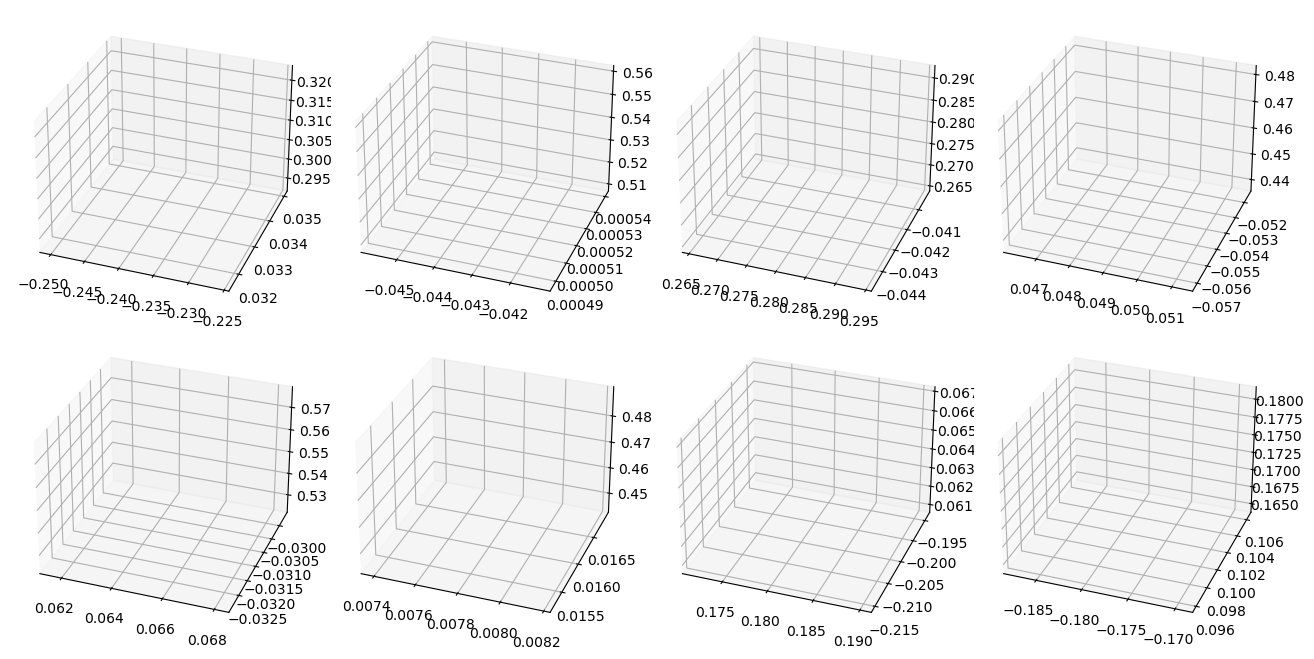

In [15]:
%matplotlib inline
fig = plt.figure(figsize = (13, 13))
fig.patch.set_alpha(0.)
# 3DAxesを追加

c_list = ["#FF0000","#00FF00","#0000FF","#FFFF00","#FF00FF","#00FFFF","#7F7F7F","#7F007F"]

ax1 = fig.add_subplot(441, projection='3d')
ax2 = fig.add_subplot(442, projection='3d')
ax3 = fig.add_subplot(443, projection='3d')
ax4 = fig.add_subplot(444, projection='3d')
ax5 = fig.add_subplot(445, projection='3d')
ax6 = fig.add_subplot(446, projection='3d')
ax7 = fig.add_subplot(447, projection='3d')
ax8 = fig.add_subplot(448, projection='3d')

ax_list = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
# 軸ラベルを設定
for i in range(8):
    x, y, z = s_curve_list[i][:,0], s_curve_list[i][:,1], s_curve_list[i][:,2]
    #x, y, z = data_list[i][0], data_list[i][1], data_list[i][2]
    ax_list[i].plot(x, y, z,"-",c=c_list[i],linewidth = 2.0)
    ax_list[i].view_init(elev=30, azim=-70)

fig.tight_layout()
plt.show()

In [703]:
mesh = o3d.io.read_triangle_mesh("polygon/quan_e_a/{}.ply".format(ind))
edges = mesh.get_non_manifold_edges(allow_boundary_edges=False)

angle = [np.pi, np.pi, 0] # pcd.rotate()
#angle = [-np.pi/2, np.pi/2, np.pi/2]
R = rotation_mat(angle)
R_mirror = np.array([[-1,0,0],
                    [0,1,0],
                    [0,0,1]])

geo = []

for j, l_c in enumerate(s_curve_list):
    points = l_c
    lines = [[i,i+1] for i in range(len(points)-1)]
    colors = [color_arr[j]/255 for i in range(len(lines))]
    #print(len(points),len(lines),len(colors))

    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),
    )
    line_set.colors = o3d.utility.Vector3dVector(colors)
    line_set.rotate(np.linalg.inv(R),(0,0,0))
    line_set.scale(10,(0,0,0))
    geo.append(line_set)

#o3d.visualization.draw_geometries(geo)
geo.append(mesh)
#geo.append(edges_to_lineset(mesh, edges, (1, 0, 0)))
o3d.visualization.draw_geometries(geo)